<a href="https://colab.research.google.com/github/victorciurlini/BERT_NER/blob/master/Treino_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Carregando API para o drive, instalando pacotes e definindo Path**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
!pip install transformers
!pip install torch
!pip install seqeval
!pip install pandas
!pip install tqdm
!pip install nltk

     |████████████████████████████████| 1.4MB 10.2MB/s 
     |████████████████████████████████| 890kB 39.4MB/s 
     |████████████████████████████████| 2.9MB 39.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8618c0cd2faf786fdad90b18da4754d79b6a544a8d0810eb65b6d5050191919c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=d08934340a4efcb463822f2203e4d7bcbaebf4d60fa5dc29f92dbff6620ee1f9
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
%cd 'drive/My Drive/TCC'
!ls

/content/drive/My Drive/TCC
 apresentacao_v1.0.pptx   ner_dataset.gsheet	        test.txt
 apresentacao_v2.0.pptx   NER.ipynb		        text_test.txt
 BERT			  orientacao_tcc.txt	        train.csv
 BERT_TRAINED		  papers		        Treino_Bert.ipynb
 config.json		 'pesquisa TCC.gdoc'	        vocab.txt
 imdb_bert		 'Planilha sem título.gsheet'
 ner_dataset.csv	  pytorch_model.bin


# **Adicionando GPU**

# **Adicionando base de dados e imprimindo amostra**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
data = pd.read_csv("train.csv", sep = '+', encoding="UTF8").fillna(method="ffill")
data.tail(15)

,Sentence #,Word,Tag
237089,Sentence: 35050,MP,B-LEGISLACAO
237090,Sentence: 35050,2.200-2/2001,I-LEGISLACAO
237091,Sentence: 35050,),O
237092,Sentence: 35050,JOSÉ,B-PESSOA
237093,Sentence: 35050,ROBERTO,I-PESSOA
237094,Sentence: 35050,FREIRE,I-PESSOA
237095,Sentence: 35050,PIMENTA,I-PESSOA
237096,Sentence: 35050,Ministro,O
237097,Sentence: 35050,Relator,O
237098,Sentence: 35050,fls,O


# **Criando e utilizando Classe para dividir base de dados em sentenças e labels, atribuindo as labels das palavras**

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
print(sentences[0])

['EMENTA', ':', 'APELAÇÃO', 'CÍVEL', '-', 'AÇÃO', 'DE', 'INDENIZAÇÃO', 'POR', 'DANOS', 'MORAIS', '-', 'PRELIMINAR', '-', 'ARGUIDA', 'PELO', 'MINISTÉRIO', 'PÚBLICO', 'EM', 'GRAU', 'RECURSAL', '-', 'NULIDADE', '-', 'AUSÊNCIA', 'DE', 'INTERVENÇÃO', 'DO', 'PARQUET']


In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# **criando set de Labels(Tags)**

In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
print(tag_values)
print(tag2idx)

['B-TEMPO', 'O', 'I-JURISPRUDENCIA', 'I-LOCAL', '.', 'I-ORGANIZACAO', 'I-TEMPO', 'B-ORGANIZACAO', 'B-JURISPRUDENCIA', 'I-PESSOA', 'B-LOCAL', 'B-PESSOA', 'B-LEGISLACAO', 'I-LEGISLACAO', 'PAD']
{'B-TEMPO': 0, 'O': 1, 'I-JURISPRUDENCIA': 2, 'I-LOCAL': 3, '.': 4, 'I-ORGANIZACAO': 5, 'I-TEMPO': 6, 'B-ORGANIZACAO': 7, 'B-JURISPRUDENCIA': 8, 'I-PESSOA': 9, 'B-LOCAL': 10, 'B-PESSOA': 11, 'B-LEGISLACAO': 12, 'I-LEGISLACAO': 13, 'PAD': 14}


# **Configurando Inputs do modelo e criando teste e validação**

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.7.0+cu101'

In [ ]:
# Variáveis de configuração
MAX_LEN = 75
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
# Utilizando vocabulário local para treinamento (neuralmind-ai/portuguese-bert)
tokenizer = BertTokenizer.from_pretrained('vocab.txt', do_lower_case=False)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [ ]:
# Função de Tokenização das palavras
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
    
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
# Criando lista de tokens/labels utilizando a função acima
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
print(tokenized_texts_and_labels[0])

(['E', '##ME', '##NT', '##A', ':', '[UNK]', '[UNK]', '-', '[UNK]', 'DE', '[UNK]', 'P', '##OR', 'D', '##AN', '##OS', 'M', '##OR', '##A', '##IS', '-', 'PR', '##EL', '##IM', '##IN', '##AR', '-', 'AR', '##G', '##U', '##ID', '##A', 'P', '##EL', '##O', '[UNK]', '[UNK]', 'E', '##M', 'G', '##RA', '##U', 'R', '##EC', '##UR', '##SA', '##L', '-', 'N', '##UL', '##ID', '##AD', '##E', '-', '[UNK]', 'DE', '[UNK]', 'DO', 'PA', '##R', '##Q', '##U', '##ET'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


In [ ]:
# Dividindo em duas listas, Palavras tokenizadas(MODELO BERT) e Labels das palavras
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
#print(tokenized_texts[0])
print(type(labels))

<class 'list'>


In [ ]:
# Vetorizando as palavras da lista tokenized_texts
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0, # configuração de tamanho máximo da lista para o treinamento, configurando tipo de string e valores para espaços em branco
                          truncating="post", padding="post") # Corte e preenchimento configurados para ocorrer após o método


In [ ]:
print(input_ids[0])
print(len(input_ids[0]))

[  192  7463  8427 22301   131   100   100   118   100 10836   100   212
  8718   250  7665  6072   213  8718 22301  6538   118 11635  9008 13270
  7073  6765   118 11741 22328 22341  6392 22301   212  9008 22317   100
   100   192 22311   278  5650 22341   257  5476 15289  5903 22327   118
   248 18199  6392 11836 22309   118   100 10836   100 15040 18868 22322
 22349 22341  9208     0     0     0     0     0     0     0     0     0
     0     0     0]
75


In [ ]:
# Vetorizando as labels da lista labels
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [ ]:
print(tags[0])

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 14 14 14 14 14 14 14 14 14
 14 14 14]


In [ ]:
# para cada idx != 0, attention_masks recebe 1.0, indicando aonde as palavras se encontram. 
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
# O nome deve ser repensado.

In [ ]:
print(attention_masks[0])
print(len(attention_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
75


In [ ]:
# separando inputs e masks para treinamento e validação, 10% validação 90% treino, usando random_state para sempre buscar a mesma amostra.
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [ ]:
#transformando entradas em matrizes para treino e teste
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
tr_inputs[0]

tensor([ 117,  171, 6330,  125, 9388,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])

In [ ]:
# TORCH.UTILS.DATA
# Cria, gera amostra randômica e faz upload da base de dados no modelo tensor para o modelo
# Treino
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)
# Validação
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
train_data[0]

(tensor([ 117,  171, 6330,  125, 9388,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]),
 tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
 tensor([ 1,  1,  1,  1,  1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 

# **Importando Modelo BERT para classificação (evolui para NER futuramente)**

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.0.1'

In [ ]:
# Criando path dentro do drive onde se encontra bert.config e o modelo bert-base-portuguese-cased
path_to_bert = 'BERT'
model = BertForTokenClassification.from_pretrained(
    path_to_bert,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False,
    from_tf=False
)

Some weights of the model checkpoint at BERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BERT and are newly initi

In [ ]:
# Definindo GPU para o modelo
model.cuda();

In [ ]:
# Usando FINETUNING para otimizar treino do modelo, utilizando optmizer  = AdamW
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
# Definindo parâmetros para treinamento do modelo
from transformers import get_linear_schedule_with_warmup

epochs = 3 # Gerações
max_grad_norm = 1.0 # Gradiente de aprendizado

# Numero total de passos de treino (lote*Numero de gerações)

total_steps = len(train_dataloader) * epochs

# Criando planejador para taxa de aprendizado
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# **Treinamento do Modelo**

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()







Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.12493053237004602







Epoch:  33%|███▎      | 1/3 [13:31<27:02, 811.34s/it]

Validation loss: 0.15719841189089823
Validation Accuracy: 0.9502419210321964

Average train loss: 0.09529656020765766







Epoch:  67%|██████▋   | 2/3 [27:02<13:31, 811.20s/it]

Validation loss: 0.15577351149510255
Validation Accuracy: 0.9512872588256377

Average train loss: 0.09139368146928084







Epoch: 100%|██████████| 3/3 [40:32<00:00, 810.94s/it]

Validation loss: 0.15577351149510255
Validation Accuracy: 0.9512872588256377



# **Imprimindo gráfico de evolução do modelo**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


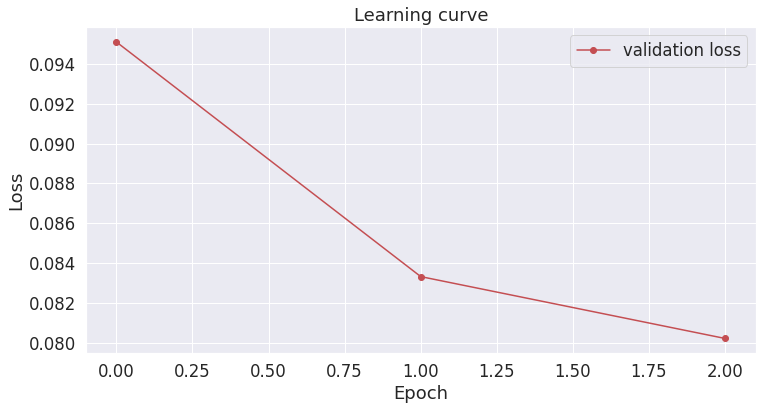

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve..plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# **Aplicando Testes com o modelo treinado**

In [ ]:
with open('text_test.txt', 'r') as f: 
    test_text = (f.read())

In [ ]:
frase = """
"Documento No: 110022-60-0-1473-1-473645 - consulta à autenticidade do documento através do site http:/www2.jfes.jus.br/jfes/d004 ."
"ARE","1233680","15341104761","2","PODER JUDICIARIO"
"""


In [ ]:
teste = """
Meu nome é Victor Ciurlini, tenho 27 anos moro em Águas claras e estudo na Universidade de Brasília
"""

In [ ]:
tokenized_sentence = tokenizer.encode(teste)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

NameError: ignored

In [ ]:
new_tokens

NameError: ignored

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

.	[CLS]
O	Meu
O	nome
O	[UNK]
B-PESSOA	Victor
I-PESSOA	Ciurlini
O	,
O	tenho
O	27
O	anos
O	moro
O	em
B-LOCAL	[UNK]
I-LOCAL	claras
O	e
O	estudo
O	na
B-LOCAL	Universidade
I-LOCAL	de
I-LOCAL	[UNK]
.	[SEP]


# **Exportando modelo treinado**

In [ ]:
conf = BertConfig.from_pretrained('BERT', num_labels=13)
# load a sequence model
bsm = BertForTokenClassification.from_pretrained('BERT', config=conf)
# get bert core model
bcm = bsm.bert
# save the core model
bcm.save_pretrained('BERT_TRAINED')

In [ ]:
import re
texto_teste_tratado = re.sub('\n\n', '\n', test_text)
texto_teste_tratado = re.sub('\(\n','',texto_teste_tratado)
texto_teste_tratado = re.sub('\)\n','',texto_teste_tratado)


In [ ]:
alphabets= "([A-Za-z])"
prefixes = "(Sr|Sra|Dr|Dra|)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace(",",",<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace(":",":<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [ ]:
texto_tratado = split_into_sentences(texto_teste_tratado)

In [ ]:
maior_frase = 0
texto_maior_frase = ''
todos_tamanhos = []
for textos in texto_tratado:
  todos_tamanhos.append(len(textos))
  if len(textos) > maior_frase:
    maior_frase = len(textos)
    texto_maior_frase = textos
print(maior_frase)
print(texto_maior_frase)
print(set(todos_tamanhos))

844
0000491-78.1999.4.02.5002 (CAUTELAR INOMINADA0010600-23.2000. 0003624-29.2002. 0001916-07.2003. .02.5001 (REINTEGRAÇAO / MANUTENÇÂO DE POSSE.02.5001 (REINTEGRAÇAO / MANUTENÇÂO DE POSSE.02.5001 (REINTEGRAÇAO / MANUTENÇÂO DE POSSE0009327-33.2005.4.02.5001 (AÇÂO DE USUCAPIÀO0103334-96.2014.4.02.5002 (REINTEGRAÇAO / MANUTENÇAO DE POSSE0103335-81.2014.4.02.5002 (REINTEGRAÇAO / MANUTENÇAO DE POSSE0000424-88.2014. BEBE ERRES ( = z -02.5002 (REINTEGRAÇAO / MANUTENÇAO DE POSSE0107394-15.2014.4.02.5002 (ORDINARIA/OUTRAS0115807-17.2014.4.02.5002 (REINTEGRAÇAO / MANUTENÇAO DE POSSE0008553-47.1998.4.02.5001 (REINTEGRAÇAO / MANUTENÇAO DE POSSE05 - Duplo Grau (X) Sim ( ) Näo £1. 1361 06 - Agravo retido ( ) Sim (X) Näo 07 - Recurso adesivo ( ) Sim (X) Näo 08 - Justiça gratuita ( ) Sim (X) Näo 09 - Segredo de Justiça ( ) Sim (X) Näo 10 - Recorrente:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,

In [ ]:
print(texto_tratado[4])

"PODER JUDICIARIO JUSTIÇA FEDERAL SEÇÂÀO JUDICIARIA DO ESPÎRITO SANTO 22 VARA FEDERAL DE CACHOEIRO DE ITAPEMIRIM JFES Fls 1473 PROCESSO N° 0011030-40.1998.4.02.5002 (98.0011030-5AUTOR(A):


In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('BERT_TRAINED/vocab.txt', do_lower_case=False)
path_to_bert = 'BERT_TRAINED'

model_bert = BertForTokenClassification.from_pretrained(
    path_to_bert,
    num_labels=14,
    output_attentions = False,
    output_hidden_states = False,
    from_tf=False,
    
)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [ ]:
# usando o pipeline funciona bem quando não importado de outro módulo... quando importamos o "bert_trained o modelo se confunde."

In [ ]:
from transformers import pipeline
NER = pipeline('ner', model=model_bert, tokenizer=tokenizer_bert, framework = 'pt', device=0)

In [ ]:
print(NER(teste))

[{'word': '[CLS]', 'score': 0.09022077172994614, 'entity': 'LABEL_6', 'index': 0}, {'word': 'Meu', 'score': 0.11424662172794342, 'entity': 'LABEL_11', 'index': 1}, {'word': 'nome', 'score': 0.14068174362182617, 'entity': 'LABEL_11', 'index': 2}, {'word': '[UNK]', 'score': 0.13210371136665344, 'entity': 'LABEL_3', 'index': 3}, {'word': 'Victor', 'score': 0.09435810148715973, 'entity': 'LABEL_9', 'index': 4}, {'word': 'C', 'score': 0.12549255788326263, 'entity': 'LABEL_8', 'index': 5}, {'word': '##iu', 'score': 0.12726427614688873, 'entity': 'LABEL_8', 'index': 6}, {'word': '##r', 'score': 0.10704368352890015, 'entity': 'LABEL_11', 'index': 7}, {'word': '##lin', 'score': 0.0991470068693161, 'entity': 'LABEL_9', 'index': 8}, {'word': '##i', 'score': 0.08939193934202194, 'entity': 'LABEL_8', 'index': 9}, {'word': ',', 'score': 0.10058434307575226, 'entity': 'LABEL_3', 'index': 10}, {'word': 'tenho', 'score': 0.11648811399936676, 'entity': 'LABEL_11', 'index': 11}, {'word': '27', 'score': 0

In [ ]:
tokenized_sentence = tokenizer.encode(texto_tratado[4])
input_ids = torch.tensor([tokenized_sentence])

tensor([[  101,   107,   212, 22317,  7545, 22322,   299, 22341, 18822, 14298,
          6765, 15749,   100,   263, 12002,  5054,  9369,   100,   299, 22341,
         18822, 14298,  6765,  5234, 15040,   100, 16566,  8427, 22317,  2336,
           354,  6765, 22301,   263, 12002,  5054,  9369, 10836, 17715, 17511,
         22317, 18469,  9689, 10836,   290,  5118,  8214, 10556, 21748, 22311,
           299, 22324,  3341,  2773, 22281, 16095, 22335, 11635, 13481,  3341,
         19715,   100, 14736,  6610, 22307,  3708,   118,  3467,   119,  6341,
           119,   678,   119, 16956,   119,  5047, 22313,   113, 15405,   119,
         14736,  6610, 22307,  3708,   118,   732, 22301, 21557,  8718,   113,
           177,   114,   131,   102]])


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
model.save_weights('bert_weights.h5')

AttributeError: ignored

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

.	[CLS]
O	"
O	PODER
I-PESSOA	JUDICIARIO
O	[UNK]
O	FEDERAL
B-LOCAL	[UNK]
I-LOCAL	JUDICIARIA
B-LOCAL	DO
.	[UNK]


In [ ]:
bert_expt_dir = "imdb_bert"
model.save_pretrained(bert_expt_dir)
tokenizer.save_pretrained(bert_expt_dir)

('imdb_bert/vocab.txt',
 'imdb_bert/special_tokens_map.json',
 'imdb_bert/added_tokens.json')

In [ ]:
bert_model = BertForTokenClassification.from_pretrained("imdb_bert")
bert_tokenizer = BertTokenizer.from_pretrained("imdb_bert")
bert_config = BertConfig.from_pretrained("imdb_bert")

In [ ]:
from transformers import pipeline
NER = pipeline('ner', model=bert_model, tokenizer=bert_tokenizer, framework = 'pt', device=0, config = bert_config)

In [ ]:
predict = NER(teste)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
for words in predict:
  print(words)

{'word': '[CLS]', 'score': 0.8476986289024353, 'entity': 'LABEL_0', 'index': 0}
{'word': 'Meu', 'score': 0.9988990426063538, 'entity': 'LABEL_6', 'index': 1}
{'word': 'nome', 'score': 0.9987429976463318, 'entity': 'LABEL_6', 'index': 2}
{'word': '[UNK]', 'score': 0.9935919046401978, 'entity': 'LABEL_6', 'index': 3}
{'word': 'Victor', 'score': 0.9572616815567017, 'entity': 'LABEL_9', 'index': 4}
{'word': 'C', 'score': 0.9976959824562073, 'entity': 'LABEL_2', 'index': 5}
{'word': '##iu', 'score': 0.9975982904434204, 'entity': 'LABEL_2', 'index': 6}
{'word': '##r', 'score': 0.9975448846817017, 'entity': 'LABEL_2', 'index': 7}
{'word': '##lin', 'score': 0.9977402091026306, 'entity': 'LABEL_2', 'index': 8}
{'word': '##i', 'score': 0.9966245889663696, 'entity': 'LABEL_2', 'index': 9}
{'word': ',', 'score': 0.9966582655906677, 'entity': 'LABEL_6', 'index': 10}
{'word': 'tenho', 'score': 0.9992043375968933, 'entity': 'LABEL_6', 'index': 11}
{'word': '27', 'score': 0.9953465461730957, 'entity':

In [ ]:
tags = {'.': "LABEL_0",
'B-LOCAL': "LABEL_1",
'I-PESSOA': "LABEL_2",
'I-LOCAL': "LABEL_3",
'I-LEGISLACAO': "LABEL_4",
'B-LEGISLACAO': "LABEL_5",
'O': "LABEL_6",
'B-ORGANIZACAO': "LABEL_7",
'I-ORGANIZACAO': "LABEL_8",
'B-PESSOA': "LABEL_9",
'I-JURISPRUDENCIA': "LABEL_10",
'B-TEMPO': "LABEL_11",
'I-TEMPO': "LABEL_12",
'B-JURISPRUDENCIA': "LABEL_13",
'PAD': "LABEL_14"}